In [3]:
import os


dir = "explanations"

# list all folders in the directory
folders = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f))]
folders = [f for f in folders if "Alkane" in f]
folders

['graph_AlkaneCarbonyl_GCN_GraphMaskExplainer',
 'graph_AlkaneCarbonyl_GCN_GNNExplainer',
 'graph_AlkaneCarbonyl_GCN_PGMExplainer',
 'graph_AlkaneCarbonyl_GCN_GradExplainer',
 'graph_AlkaneCarbonyl_GCN_Random']

In [5]:
import json

import pandas as pd

for fl in folders:
    file_path = os.path.join(dir, fl, "complexes_metrics.json")
    graph_path = os.path.join(dir, fl, "graph_metrics.json")

    try:
        print(f"Loading data from {file_path}")
        with open(file_path, "r") as f:
            data = json.load(f)
    
        with open(graph_path, "r") as f:
            graph_data = json.load(f)

        from pprint import pprint
        best_per_seed = []

        # get best per seed for each combo of hyperparameters prop_method, alpha_c, alpha_e
        hp_combos = set()
        prop_methods = set()
        per_hp_metrics = {}
        for seed in data.keys():
            metrics = data[seed]

            # metrics is a list of dicts
            for metric in metrics:
                prop_method = metric["prop_method"]
                alpha_c = metric["alpha_c"]
                alpha_e = metric["alpha_e"]
                
                prop_methods.add(prop_method)

                hp_combos.add((prop_method, alpha_c, alpha_e))
                
                if (prop_method, alpha_c, alpha_e) not in per_hp_metrics:
                    per_hp_metrics[(prop_method, alpha_c, alpha_e)] = []
                
                per_hp_metrics[(prop_method, alpha_c, alpha_e)].append(metric)
        
        # get the best alpha_c, alpha_e for each prop_method
        best_per_hp = {}
        for hp in per_hp_metrics.keys():
            metrics = per_hp_metrics[hp]
            
            jaccards = [metric["jaccard"] for metric in metrics]
            best_idx = jaccards.index(max(jaccards))
            best_per_hp[hp] = metrics[best_idx]

            print(f"{fl}: Best for {hp}: {best_per_hp[hp]['jaccard']}")

        # get the avg
        avg_per_hp = {}
        for hp in per_hp_metrics.keys():
            metrics = per_hp_metrics[hp]
            
            avg = {}
            for metric in metrics:
                for key in metric.keys():
                    if key in ["prop_method", "alpha_c", "alpha_e"]:
                        continue
                    if key not in avg:
                        avg[key] = 0
                    avg[key] += metric[key]
            
            for key in avg.keys():
                avg[key] /= len(metrics)
            
            avg_per_hp[hp] = avg

        x = list(avg_per_hp.keys())
        ys = {}
        for metric in avg_per_hp[x[0]].keys():
            y = [avg_per_hp[hp][metric] for hp in x]
            ys[metric] = y
        
        # get best  performing metrics for each prop_method based on jaccard

        best_per_prop_method = {}
        for prop_method in prop_methods:
            best_per_prop_method[prop_method] = {}
            
            # order the metrics by jaccard
            jaccards = []
            for hp in x:
                if hp[0] == prop_method:
                    jaccards.append((hp, avg_per_hp[hp]["jaccard"]))
            
            jaccards = sorted(jaccards, key=lambda x: x[1], reverse=True)
            
            best_per_prop_method[prop_method] = avg_per_hp[jaccards[0][0]]


        data = best_per_prop_method

        data["graph"] = graph_data["average"]
        # Convert data to a suitable format for Seaborn
        df_data = []
        for prop_method, metrics in data.items():
            for metric_name, values in metrics.items():
                if metric_name in ["accuracy", "precision", "recall"]:
                    continue
                df_data.append(
                    {
                        "Propagation Method": prop_method,
                        "Metric": metric_name,
                        "Average Score": values,
                    }
                )

        df = pd.DataFrame(df_data)
        
        # save the data 
        print('.')
        df.to_csv(f"metrics/{fl}_metrics.csv", index=False)
    
    except Exception as e:
        print(e)
        print(f"Could not load data from {file_path}")
        continue


Loading data from explanations/graph_AlkaneCarbonyl_GCN_GraphMaskExplainer/complexes_metrics.json
graph_AlkaneCarbonyl_GCN_GraphMaskExplainer: Best for ('direct_prop', 0.5, 0.5): 0.07319519238324164
graph_AlkaneCarbonyl_GCN_GraphMaskExplainer: Best for ('direct_prop', 1.0, 0): 0.074053404257735
graph_AlkaneCarbonyl_GCN_GraphMaskExplainer: Best for ('direct_prop', 1.0, 0.5): 0.074053404257735
graph_AlkaneCarbonyl_GCN_GraphMaskExplainer: Best for ('direct_prop', 1.0, 1.0): 0.074053404257735
graph_AlkaneCarbonyl_GCN_GraphMaskExplainer: Best for ('direct_prop', 1.0, 1.5): 0.074053404257735
graph_AlkaneCarbonyl_GCN_GraphMaskExplainer: Best for ('direct_prop', 1.5, 0): 0.074053404257735
graph_AlkaneCarbonyl_GCN_GraphMaskExplainer: Best for ('direct_prop', 1.5, 0.5): 0.074053404257735
graph_AlkaneCarbonyl_GCN_GraphMaskExplainer: Best for ('direct_prop', 1.5, 1.0): 0.074053404257735
graph_AlkaneCarbonyl_GCN_GraphMaskExplainer: Best for ('direct_prop', 1.5, 1.5): 0.074053404257735
graph_AlkaneC

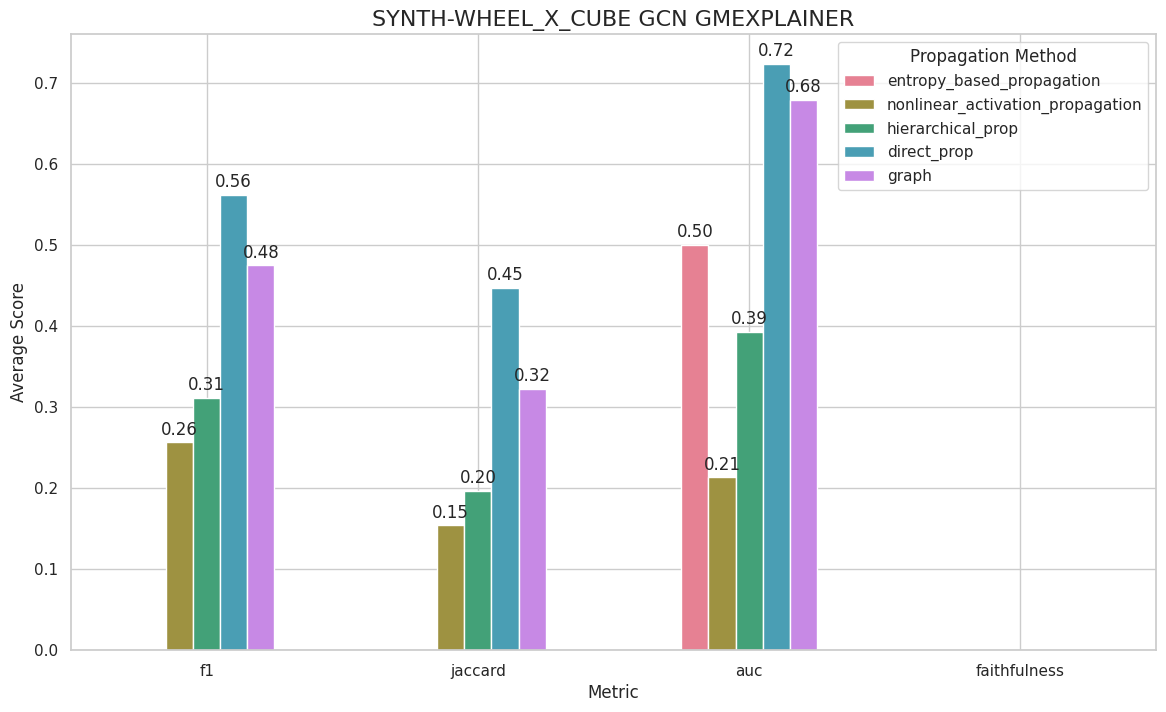

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict



sns.set(style="whitegrid")  # Set the Seaborn style

# fill the "graph" bars with a different style

plt.figure(figsize=(14, 8))  # Set the figure size
barplot = sns.barplot(
    x="Metric",
    y="Average Score",
    hue="Propagation Method",
    data=df,
    palette="husl",
    capsize=0.1,
    width=0.5,
)

plt.xlabel("Metric")
plt.ylabel("Average Score")
plt.title("SYNTH-WHEEL_X_CUBE GCN GMEXPLAINER", fontsize=16)
plt.legend(title="Propagation Method")
plt.grid(True)
# plt.tight_layout()  # Adjust the layout

# add the actual values on top of the bars
for p in barplot.patches:
    if p.get_height() <= 0:
        continue
    barplot.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

plt.show()